In [2]:

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd

In [3]:
df = pd.read_csv('D:\datasets\coffee.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


In [5]:
df

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD
...,...,...,...,...,...,...,...
5741,2022-08-29,240.55,240.55,240.55,240.50,1,USD
5742,2022-08-30,238.75,241.75,238.75,239.15,14,USD
5743,2022-08-31,240.75,240.75,239.65,239.10,12,USD
5744,2022-09-01,238.55,238.55,236.60,236.35,6,USD


In [6]:
df.Currency.unique()

array(['USD'], dtype=object)

In [7]:
len(df)

5746

In [8]:
series = df[['Close']].values

In [9]:
type(series)

numpy.ndarray

In [10]:
series

array([[116.5 ],
       [116.25],
       [118.6 ],
       ...,
       [239.1 ],
       [236.35],
       [228.42]])

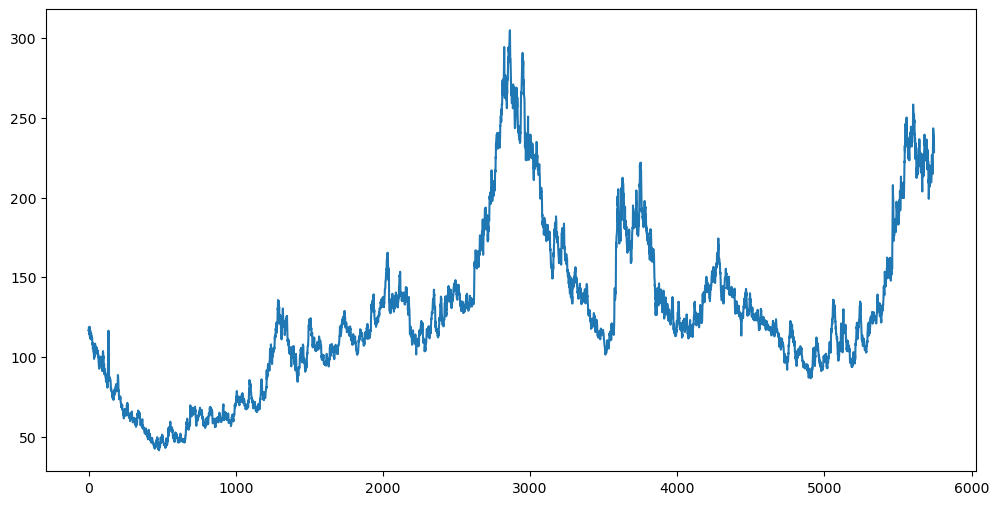

In [11]:
plt.figure(figsize=(12,6))
plt.plot(series)
plt.show()

In [12]:
#Normalizing

def normalize_series(series) : 
    original_max = max(series)
    original_min = min(series)
    normalized_series = (series - min(series))/(max(series)-min(series))
    return normalized_series, original_max, original_min

In [13]:
def denormalized_series(series,original_min,original_max):
    return(series*(original_max-original_min))+original_min

In [14]:
norm_series, original_max, original_min = normalize_series(series)

In [15]:
norm_series

array([[0.28473804],
       [0.28378891],
       [0.29271071],
       ...,
       [0.75018983],
       [0.73974943],
       [0.70964313]])

In [16]:
print(original_max)
print(original_min)
print(max(series))
print(min(series))
series

[304.9]
[41.5]
[304.9]
[41.5]


array([[116.5 ],
       [116.25],
       [118.6 ],
       ...,
       [239.1 ],
       [236.35],
       [228.42]])

In [17]:
#Denormalizing

de_series = denormalized_series(norm_series, original_min, original_max)
de_series

array([[116.5 ],
       [116.25],
       [118.6 ],
       ...,
       [239.1 ],
       [236.35],
       [228.42]])

In [18]:
#Splitting

def split_series(series, split_size_percentage):
    split_size = int(len(series)*split_size_percentage)
    return series[:split_size], series[split_size:]

In [19]:
train_set, validate_set = split_series(norm_series, 0.8)

In [20]:
train_set.shape

(4596, 1)

In [21]:
validate_set.shape

(1150, 1)

In [22]:
#Data Windowing

def windowed_dataset(series, window_size, batch_size, buffer_size):
    series = tf.data.Dataset.from_tensor_slices(series)
    series = series.window(window_size +1, shift = 1, drop_remainder = True)
    series = series.flat_map(lambda x: x.batch(window_size+1))
    series = series.map(lambda x: (x[:-1], x[-1]))
    series = series.shuffle(buffer_size)
    series = series.batch(batch_size).prefetch(1)
    return series

In [23]:
window_size = 20
batch_size = 32
buffer_size = 1000
train_dataseries = windowed_dataset(train_set, window_size, batch_size, buffer_size)
for x,y in train_dataseries.take(1):
    print(x.shape)
    print(y.shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
(32, 20, 1)
(32, 1)


In [24]:
#Modeling - selecting the best learning rate

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64 , return_sequences = True , input_shape = [window_size , 1]), #1-> because its a univarient
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(10 , activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 50,581
Trainable params: 50,581
Non-trainable params: 0
_________________________________________________________________


In [26]:
initial_weights = model.get_weights()

In [27]:
model.compile(loss = tf.keras.losses.Huber() , optimizer = tf.keras.optimizers.SGD(momentum = 0.9) , metrics = ['mae'])

In [28]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

In [29]:
history = model.fit(train_dataseries , epochs = 150 , callbacks = [lr_scheduler])

Epoch 1/150
143/143 [==============================] - 5s 15ms/step - loss: 0.0831 - mae: 0.3481 - lr: 1.0000e-08
Epoch 2/150
143/143 [==============================] - 1s 9ms/step - loss: 0.0831 - mae: 0.3481 - lr: 1.1220e-08
Epoch 3/150
143/143 [==============================] - 1s 9ms/step - loss: 0.0831 - mae: 0.3481 - lr: 1.2589e-08
Epoch 4/150
143/143 [==============================] - 1s 9ms/step - loss: 0.0831 - mae: 0.3480 - lr: 1.4125e-08
Epoch 5/150
143/143 [==============================] - 1s 9ms/step - loss: 0.0831 - mae: 0.3480 - lr: 1.5849e-08
Epoch 6/150
143/143 [==============================] - 1s 9ms/step - loss: 0.0831 - mae: 0.3479 - lr: 1.7783e-08
Epoch 7/150
143/143 [==============================] - 1s 9ms/step - loss: 0.0831 - mae: 0.3479 - lr: 1.9953e-08
Epoch 8/150
143/143 [==============================] - 1s 10ms/step - loss: 0.0830 - mae: 0.3478 - lr: 2.2387e-08
Epoch 9/150
143/143 [==============================] - 1s 9ms/step - loss: 0.0830 - mae: 0.347

In [32]:
#Modeling - learning with the learning rate

lr_selected = 3e-3

In [33]:
model_2 = model
model_2.set_weights(initial_weights)

In [34]:
model_2.compile(loss = tf.keras.losses.Huber() , optimizer = tf.keras.optimizers.SGD(momentum = 0.9 , lr = lr_selected) , metrics = ['mae'])
history = model_2.fit(train_dataseries , epochs = 500)

Epoch 1/500
143/143 [==============================] - 4s 9ms/step - loss: 0.0064 - mae: 0.0832
Epoch 2/500
143/143 [==============================] - 1s 9ms/step - loss: 8.3350e-04 - mae: 0.0305
Epoch 3/500
143/143 [==============================] - 1s 9ms/step - loss: 3.5778e-04 - mae: 0.0193
Epoch 4/500
143/143 [==============================] - 1s 9ms/step - loss: 3.6310e-04 - mae: 0.0195
Epoch 5/500
143/143 [==============================] - 1s 9ms/step - loss: 3.5042e-04 - mae: 0.0192
Epoch 6/500
143/143 [==============================] - 1s 9ms/step - loss: 3.4815e-04 - mae: 0.0190
Epoch 7/500
143/143 [==============================] - 1s 9ms/step - loss: 3.4907e-04 - mae: 0.0191
Epoch 8/500
143/143 [==============================] - 1s 9ms/step - loss: 3.4432e-04 - mae: 0.0189
Epoch 9/500
143/143 [==============================] - 1s 9ms/step - loss: 3.4120e-04 - mae: 0.0189
Epoch 10/500
143/143 [==============================] - 1s 9ms/step - loss: 3.4752e-04 - mae: 0.0191
Epo

In [35]:
#Plotting validations vs predictions

def model_forecast(model , series , window_size , batch_size):
    series = tf.data.Dataset.from_tensor_slices(series)
    series = series.window(window_size , shift = 1 , drop_remainder = True) 
    series = series.flat_map(lambda x: x.batch(window_size))
    series = series.batch(batch_size).prefetch(1)
    predictions = model.predict(series)
    return predictions

In [36]:
print(validate_set)
print(window_size)
print(batch_size)

[[0.30334093]
 [0.30846621]
 [0.30865604]
 ...
 [0.75018983]
 [0.73974943]
 [0.70964313]]
20
32


In [37]:
predictions = model_forecast(model_2 , validate_set , window_size , batch_size)
results = np.array(predictions).squeeze()

36/36 [==============================] - 1s 6ms/step


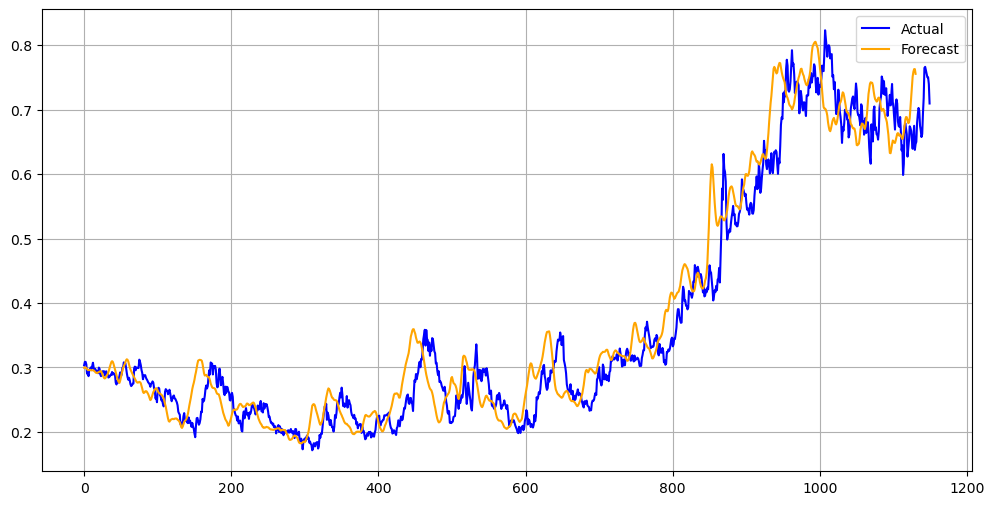

In [38]:
plt.figure(figsize = (12 , 6))
plt.plot(validate_set , 'b' , label = 'Actual')
plt.plot(results , 'orange' , label = 'Forecast')
plt.grid()
plt.legend()
plt.show()

In [39]:
#mae and mse
np.mean(tf.keras.metrics.mean_squared_error(validate_set , results))

0.06789719

In [40]:
np.mean(tf.keras.metrics.mean_absolute_error(validate_set , results))

0.1916111